In [1]:
import pandas as pd
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Data processing

In [5]:
data=pd.read_csv('your data path')

In [6]:
data.head()

timestamp    number  gas_used  gas_limit  base_fee_per_gas
0  2023-03-21 00:00:11 UTC  16872313  29872569   30000000       14709149536
1  2023-03-21 00:00:23 UTC  16872314  13937940   30000000       16532173214
2  2023-03-21 00:00:35 UTC  16872315  19559490   30000000       16385855215
3  2023-03-21 00:00:47 UTC  16872316  13826473   30000000       17008448073
4  2023-03-21 00:00:59 UTC  16872317  20820719   30000000       16842115798

In [7]:
import pandas as pd
new_df = data.drop_duplicates(subset='number', keep='first')

In [8]:
new_df=new_df[["timestamp","number","gas_used","gas_limit","base_fee_per_gas"]]

In [9]:
new_df["base_fee_per_gas"] = new_df["base_fee_per_gas"]*10**-9

In [10]:
new_df.head()

timestamp    number  gas_used  gas_limit  base_fee_per_gas
0  2023-03-21 00:00:11 UTC  16872313  29872569   30000000         14.709150
1  2023-03-21 00:00:23 UTC  16872314  13937940   30000000         16.532173
2  2023-03-21 00:00:35 UTC  16872315  19559490   30000000         16.385855
3  2023-03-21 00:00:47 UTC  16872316  13826473   30000000         17.008448
4  2023-03-21 00:00:59 UTC  16872317  20820719   30000000         16.842116

In [11]:
new_df['gas_fraction'] = new_df['gas_used'] / new_df['gas_limit']

In [12]:
new_df['gas_target'] = (new_df['gas_used']-(new_df['gas_limit']/2)) / (new_df['gas_limit']/2)

In [13]:
org_data=np.array(new_df)

## 4 Machine learning medhods

In [14]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import tensorflow.compat.v2 as tf
import matplotlib.pyplot as plt
import xgboost

In [15]:
import copy
x=[]
y=[]
for i in range(len(org_data)-10):
  base=org_data[i:i+11,4].tolist()
  gas_frc=org_data[i:i+10,5].tolist()
  now=np.concatenate((base, gas_frc),axis=0)
  now=now.tolist()
  x.append(now)
  y.append(org_data[i+10,6])
x=np.array(x)
y=np.array(y)

## Linear Regression

0.12497945007235127
0.1232660189285254
0.11655808500097173
0.1088873888698169
0.1213640078300685


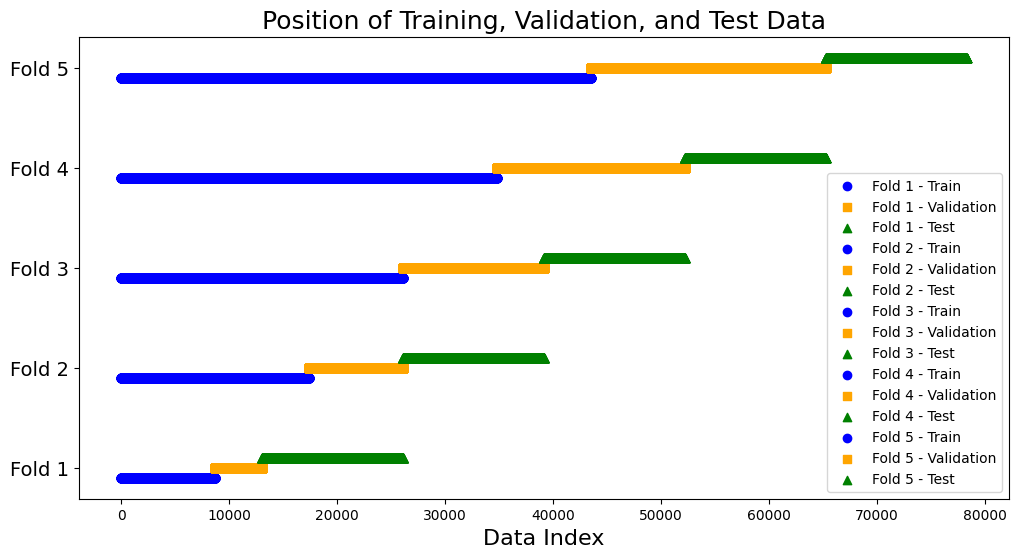

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

reg = linear_model.LinearRegression()
train_indices = []
validation_indices = []
test_indices = []
n_splits = 5
tss = TimeSeriesSplit(n_splits)
tss2 = TimeSeriesSplit(2)

for train_index, test_index in tss.split(x):
    x_train, x_test = x[train_index, :], x[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    for train_index, vali_index in tss2.split(x_train):
        x_train, x_vali = x[train_index, :], x[vali_index, :]
        y_train, y_vali = y[train_index], y[vali_index]
    train_indices.append(train_index)
    validation_indices.append(vali_index)
    test_indices.append(test_index)
    reg.fit(x_train, y_train)
    pred_reg = reg.predict(x_test)
    print(mean_squared_error(y_test, pred_reg))

offset = 0.1

plt.figure(figsize=(12, 6))
for i in range(n_splits):

    plt.scatter(train_indices[i], np.full_like(train_indices[i], i + 1) - offset, label=f'Fold {i + 1} - Train', marker='o', color='blue')

    plt.scatter(validation_indices[i], np.full_like(validation_indices[i], i + 1), label=f'Fold {i + 1} - Validation', marker='s', color='orange')

    plt.scatter(test_indices[i], np.full_like(test_indices[i], i + 1) + offset, label=f'Fold {i + 1} - Test', marker='^', color='green')

plt.yticks(range(1, n_splits + 1), labels=[f'Fold {i + 1}' for i in range(n_splits)], fontsize=14)
plt.xlabel('Data Index', fontsize=16)
plt.title('Position of Training, Validation, and Test Data', fontsize=18)
plt.legend(fontsize=10)
plt.show()


##DNN

In [17]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
reg = linear_model.LinearRegression()
train_indices = []
validation_indices = []
test_indices = []
n_splits = 5
result=[]
tss = TimeSeriesSplit(n_splits)
tss2 = TimeSeriesSplit(2)
for train_index, test_index in tss.split(x):
    tf.enable_v2_behavior()
    model_stability = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, activation = 'tanh',use_bias=True),
        tf.keras.layers.Dense(128, activation = 'linear',use_bias=True),
        tf.keras.layers.Dense(128, activation = 'tanh',use_bias=True),
        tf.keras.layers.Dense(1)
    ]
    )
    model_stability.compile(loss=tf.keras.losses.mean_squared_error,
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                      metrics=['mse'])

    training_callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(patience = 7, factor = 0.1, min_lr = 0.00001, verbose = 1),
        tf.keras.callbacks.EarlyStopping(patience = 12, restore_best_weights = True, verbose=1),
    ]

    x_train, x_test = x[train_index, :], x[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    for train_index, vali_index in tss2.split(x_train):
      x_train, x_vali = x[train_index, :], x[vali_index,:]
      y_train, y_vali = y[train_index], y[vali_index]
    train_indices.append(train_index)
    validation_indices.append(vali_index)
    test_indices.append(test_index)
    model_stability.fit(x_train, y_train, batch_size=64, epochs=100,callbacks=training_callbacks,validation_data=(x_vali,y_vali))
    pred_reg=model_stability.predict(x_test)
    result.append(mean_squared_error(y_test, pred_reg))
    print(mean_squared_error(y_test, pred_reg))


Epoch 1/100
136/136 [==============================] - 2s 6ms/step - loss: 0.1843 - mse: 0.1843 - val_loss: 0.1281 - val_mse: 0.1281 - lr: 0.0010
Epoch 2/100
136/136 [==============================] - 1s 5ms/step - loss: 0.1298 - mse: 0.1298 - val_loss: 0.1227 - val_mse: 0.1227 - lr: 0.0010
Epoch 3/100
136/136 [==============================] - 1s 6ms/step - loss: 0.1262 - mse: 0.1262 - val_loss: 0.1199 - val_mse: 0.1199 - lr: 0.0010
Epoch 4/100
136/136 [==============================] - 1s 5ms/step - loss: 0.1272 - mse: 0.1272 - val_loss: 0.1298 - val_mse: 0.1298 - lr: 0.0010
Epoch 5/100
136/136 [==============================] - 1s 6ms/step - loss: 0.1255 - mse: 0.1255 - val_loss: 0.1170 - val_mse: 0.1170 - lr: 0.0010
Epoch 6/100
136/136 [==============================] - 1s 5ms/step - loss: 0.1182 - mse: 0.1182 - val_loss: 0.1185 - val_mse: 0.1185 - lr: 0.0010
Epoch 7/100
136/136 [==============================] - 1s 4ms/step - loss: 0.1205 - mse: 0.1205 - val_loss: 0.1155 - val_mse

## XGBoost

In [18]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
reg = linear_model.LinearRegression()
train_indices = []
validation_indices = []
test_indices = []
n_splits = 5
result=[]
tss = TimeSeriesSplit(n_splits)
tss2 = TimeSeriesSplit(2)
for train_index, test_index in tss.split(x):
    x_train, x_test = x[train_index, :], x[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    for train_index, vali_index in tss2.split(x_train):
      x_train, x_vali = x[train_index, :], x[vali_index,:]
      y_train, y_vali = y[train_index], y[vali_index]
    train_indices.append(train_index)
    validation_indices.append(vali_index)
    test_indices.append(test_index)
    model = xgboost.XGBRegressor()
    model.fit(x_train, y_train)
    pred_reg=model.predict(x_test)
    result.append(mean_squared_error(y_test, pred_reg))
    print(mean_squared_error(y_test, pred_reg))


0.12260423842432859
0.1129450415694429
0.09961083337293349
0.09394534402873217
0.10429804165796275


##Lstm

In [19]:
import copy
x=[]
y=[]
for i in range(len(org_data)-10):
  temp=[[0,0]]
  base=org_data[i:i+10,4:6].tolist()
  temp[0][0]=org_data[i+10,4]
  base.extend(temp)
  x.append(base)
  y.append(org_data[i+10,6])

x=np.array(x)
y=np.array(y)

In [20]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
reg = linear_model.LinearRegression()
n_splits = 5
result=[]
tss = TimeSeriesSplit(n_splits)
tss2 = TimeSeriesSplit(2)
for train_index, test_index in tss.split(x):
    x_train, x_test = x[train_index, :], x[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    for train_index, vali_index in tss2.split(x_train):
      x_train, x_vali = x[train_index, :], x[vali_index,:]
      y_train, y_vali = y[train_index], y[vali_index]
    train_indices.append(train_index)
    validation_indices.append(vali_index)
    test_indices.append(test_index)
    input_shape = (11, 2)

    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(24, input_shape=input_shape, return_sequences=True),
        tf.keras.layers.LSTM(24, return_sequences=True),
        tf.keras.layers.LSTM(24),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    training_callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(patience = 7, factor = 0.1, min_lr = 0.00001, verbose = 1),
        tf.keras.callbacks.EarlyStopping(patience = 12, restore_best_weights = True, verbose=1),
    ]
    model.compile(loss=tf.keras.losses.mean_squared_error,
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                      metrics=['mse'])

    model.fit(x_train, y_train, batch_size=64, epochs=100,callbacks=training_callbacks,validation_data=(x_vali,y_vali))
    pred_reg=model.predict(x_test)
    result.append(mean_squared_error(y_test, pred_reg))



Epoch 1/100
136/136 [==============================] - 10s 31ms/step - loss: 0.1338 - mse: 0.1338 - val_loss: 0.1346 - val_mse: 0.1346 - lr: 0.0010
Epoch 2/100
136/136 [==============================] - 4s 31ms/step - loss: 0.1334 - mse: 0.1334 - val_loss: 0.1347 - val_mse: 0.1347 - lr: 0.0010
Epoch 3/100
136/136 [==============================] - 3s 20ms/step - loss: 0.1335 - mse: 0.1335 - val_loss: 0.1351 - val_mse: 0.1351 - lr: 0.0010
Epoch 4/100
136/136 [==============================] - 3s 24ms/step - loss: 0.1333 - mse: 0.1333 - val_loss: 0.1346 - val_mse: 0.1346 - lr: 0.0010
Epoch 5/100
136/136 [==============================] - 3s 21ms/step - loss: 0.1333 - mse: 0.1333 - val_loss: 0.1348 - val_mse: 0.1348 - lr: 0.0010
Epoch 6/100
136/136 [==============================] - 3s 25ms/step - loss: 0.1334 - mse: 0.1334 - val_loss: 0.1351 - val_mse: 0.1351 - lr: 0.0010
Epoch 7/100
136/136 [==============================] - 4s 26ms/step - loss: 0.1333 - mse: 0.1333 - val_loss: 0.1346 -

#Training eporch for DNN

In [21]:
import copy
x=[]
y=[]
for i in range(len(org_data)-10):
  base=org_data[i:i+11,4].tolist()
  gas_frc=org_data[i:i+10,5].tolist()
  now=np.concatenate((base, gas_frc),axis=0)
  now=now.tolist()
  x.append(now)
  y.append(org_data[i+10,6])
x=np.array(x)
y=np.array(y)

In [22]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
tss = TimeSeriesSplit(n_splits=2)
for train_index, test_index in tss.split(x):
    x_train, x_test = x[train_index, :], x[test_index,:]
    y_train, y_test = y[train_index], y[test_index]

In [23]:
import tensorflow as tf
import matplotlib.pyplot as plt

model_stability = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, activation = 'tanh',use_bias=True),
        tf.keras.layers.Dense(128, activation = 'linear',use_bias=True),
        tf.keras.layers.Dense(128, activation = 'tanh',use_bias=True),
        tf.keras.layers.Dense(1)
    ]
    )
training_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(patience=7, factor=0.1, min_lr=0.000001, verbose=1),
    tf.keras.callbacks.EarlyStopping(patience=12, restore_best_weights=True, verbose=1),
]
model_stability.compile(loss=tf.keras.losses.mean_squared_error,
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                      metrics=['mse'])


history = model_stability.fit(x_train, y_train, batch_size=512, epochs=100, callbacks=training_callbacks,validation_data=(x_test,y_test))


Epoch 1/100
102/102 [==============================] - 2s 9ms/step - loss: 0.1359 - mse: 0.1359 - val_loss: 0.1187 - val_mse: 0.1187 - lr: 1.0000e-04
Epoch 2/100
102/102 [==============================] - 1s 7ms/step - loss: 0.1247 - mse: 0.1247 - val_loss: 0.1164 - val_mse: 0.1164 - lr: 1.0000e-04
Epoch 3/100
102/102 [==============================] - 1s 10ms/step - loss: 0.1215 - mse: 0.1215 - val_loss: 0.1135 - val_mse: 0.1135 - lr: 1.0000e-04
Epoch 4/100
102/102 [==============================] - 1s 13ms/step - loss: 0.1194 - mse: 0.1194 - val_loss: 0.1131 - val_mse: 0.1131 - lr: 1.0000e-04
Epoch 5/100
102/102 [==============================] - 1s 13ms/step - loss: 0.1181 - mse: 0.1181 - val_loss: 0.1116 - val_mse: 0.1116 - lr: 1.0000e-04
Epoch 6/100
102/102 [==============================] - 1s 10ms/step - loss: 0.1173 - mse: 0.1173 - val_loss: 0.1102 - val_mse: 0.1102 - lr: 1.0000e-04
Epoch 7/100
102/102 [==============================] - 1s 7ms/step - loss: 0.1164 - mse: 0.1164 

#Prediction using DNN

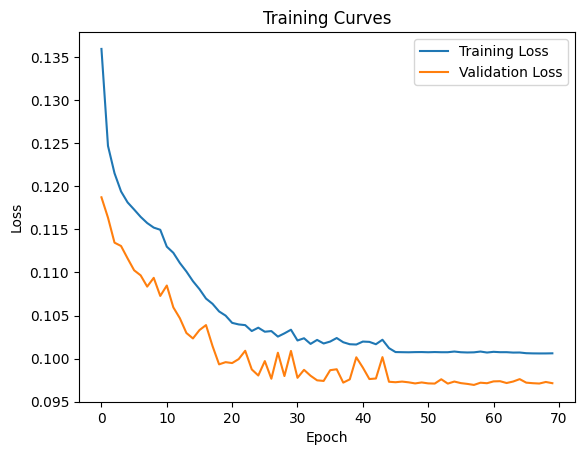

In [24]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Curves')
plt.legend()
plt.show()

In [25]:
pred = model_stability.predict(x_test)

816/816 [==============================] - 1s 2ms/step


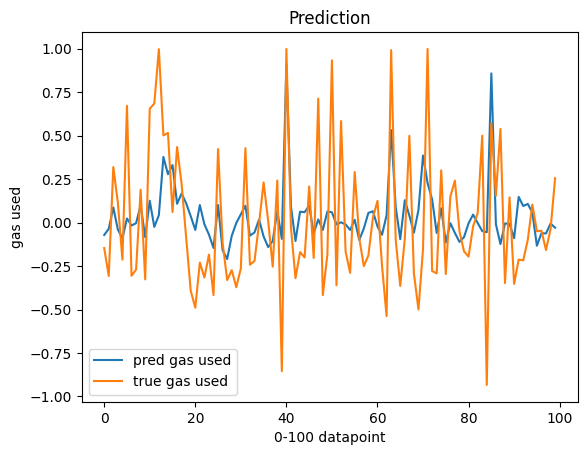

In [26]:
plt.plot(pred[0:100], label='pred gas used')
plt.plot(y_test[0:100], label='true gas used')
plt.title('Prediction')
plt.xlabel('0-100 datapoint')
plt.ylabel('gas used')
plt.legend()
plt.show()

#Prediction Using Linear Regression

In [27]:
reg = linear_model.LinearRegression()
reg.fit(x_train, y_train)
pred = reg.predict(x_test)

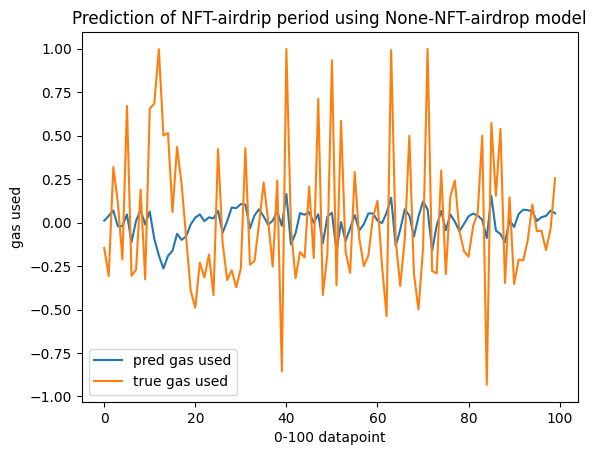

In [28]:
plt.plot(pred[0:100], label='pred gas used')
plt.plot(y_test[0:100], label='true gas used')
plt.title('Prediction of NFT-airdrip period using None-NFT-airdrop model')
plt.xlabel('0-100 datapoint')
plt.ylabel('gas used')
plt.legend()
plt.show()